In [97]:
import cudatoolkit

ModuleNotFoundError: No module named 'cudatoolkit'

In [1]:
import pandas as pd
import numpy as np
from significance_of_mean_cuda import significance_of_mean_cuda
import time
from utils import MW, ttests, qvalues
import sklearn

In [2]:
!ls "./data/nature18003-s2/"

CPTAC_BC_SupplementaryTable01.xlsx  CPTAC_BC_SupplementaryTable03.xlsx


In [3]:
path = "./data/nature18003-s2/"

In [4]:
T1 = pd.read_excel(path + "CPTAC_BC_SupplementaryTable01.xlsx")
T3 = pd.read_excel(path + "CPTAC_BC_SupplementaryTable03.xlsx")

## Extract important column headings

In [5]:
paiteint_id = T1.columns[0]
stats_col = T1.columns[5: 5 + 3]

### Patient column  

In [6]:
paiteint_id

'Sample ID'

### Cancer phenotype coulmns

In [7]:
stats_col

Index(['ER Status', 'PR Status', 'HER2 Status'], dtype='object')

### Check viable phenotype status

In [8]:
all_lab = list()
for r in T1[stats_col].iterrows():
    all_lab += list(r[1].values)

In [9]:
list(set(all_lab))

['Indeterminate', 'Equivocal', 'Negative', 'Positive']

### Let's drop patient with "Equivocal" and "Indeterminate" status

In [10]:
drop_label = ['Indeterminate', 'Equivocal']

In [11]:
T1.head()

,Sample ID,TCGA ID,Biospecimen Barcode Side,UIUD,PAM50,ER Status,PR Status,HER2 Status,QC Status,Proteome Cluster (see Fig. 3b),...,iTRAQReporterIon,CommonControl,GATA3 Mutation,PIK3CA Mutation,TP53 Mutation,PIK3CA missense mutation in helical domain all tumors,PIK3CA missense mutation in kinase domain all tumors,TP53 Nonsense/Frameshift all tumors,TP53 Missense mutation all tumors,TP53 missense mutations in DNA binding domain all tumors
0,A2-A0CM,TCGA-A2-A0CM,TCGA-A2-A0CM-01A-11-A21V-30,330F7598-824C-4CD6-9303-A27FE74A6695,Basal,Negative,Negative,Negative,pass,1.0,...,116,YES,NaN,NaN,Frame_Shift_Del|Somatic|p.E204fs,0.0,0.0,1.0,NaN,NaN
1,A2-A0D2,TCGA-A2-A0D2,TCGA-A2-A0D2-01A-12-A21W-30,308CCD79-C164-4397-92BC-A1CD243C8E7D,Basal,Negative,Negative,Negative,pass,1.0,...,114,NO,NaN,NaN,Frame_Shift_Del|Somatic|p.P318fs,0.0,0.0,1.0,NaN,NaN
2,A2-A0EQ,TCGA-A2-A0EQ,TCGA-A2-A0EQ-01A-41-A21W-30,04217F65-2907-478B-B0C5-EB65370198DA,Her2,Negative,Negative,Positive,pass,1.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.H1047R,In_Frame_Del|Somatic|p.IY162in_frame_delN,NaN,1.0,NaN,NaN,NaN
3,A2-A0EV,TCGA-A2-A0EV,TCGA-A2-A0EV-01A-41-A21V-30,38F98E5F-7FA4-4C89-8D81-516CF865BEEB,LumA,Positive,Positive,Negative,pass,3.0,...,114,NO,NaN,In_Frame_Ins|Somatic|p.E469in_frame_insDK,NaN,NaN,NaN,0.0,0.0,0.0
4,A2-A0EX,TCGA-A2-A0EX,TCGA-A2-A0EX-01A-41-A21V-30,78271500-147B-40C5-B789-0CF0C7CDBCE2,LumA,Positive,Positive,Negative,pass,3.0,...,116,NO,NaN,Missense_Mutation|Somatic|p.E545K,NaN,1.0,NaN,0.0,0.0,0.0


In [12]:
mask1 = [True if (len(set(r[1].values) & set(drop_label)) == 0) else False for r in T1[stats_col].iterrows()]
T1 = T1[mask1]
T1.reset_index(drop=True, inplace=True)

### Let's divide the dataframe into two dataframes with triple negative (TN) and non-triple negative (NTN)

In [13]:
mask2 = [all([True if v=='Negative' else False for v in r[1].values] ) for r in T1[stats_col].iterrows()]

T1_TNP = T1[np.array(mask2)]
T1_TNP.reset_index(drop=True, inplace=True)

T1_not_TNP = T1[~np.array(mask2)]
T1_not_TNP.reset_index(drop=True, inplace=True)



### Obtain patient ids for NT and NTN

In [14]:
TNPpateintIds = T1_TNP[paiteint_id].values
NotTNPpateintIds = T1_not_TNP[paiteint_id].values

### Remove genes (rows) containing NaN for both TN and NTN i.e., make sure all patients have same the gene when comparing.

In [15]:
def getpatientId(ids):
    patitentList = list()
    for i in ids:
        p_id = T3[T3.columns[[i in c for c in T3.columns]]].columns
        patitentList += list(p_id)
    return patitentList

In [16]:
only_patientDf = T3[getpatientId(NotTNPpateintIds) + getpatientId(TNPpateintIds)]

In [17]:
only_patientDf.dropna(inplace=True)

/home/ekvall/anaconda3/envs/kth-cluster/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
NotTNP_df =  only_patientDf[getpatientId(NotTNPpateintIds)]
TNP_df =  only_patientDf[getpatientId(TNPpateintIds)]

In [19]:
NotTNP_Arr, TNP_Arr =NotTNP_df.values, TNP_df.values

In [20]:
NotTNP_Arr.shape

(8051, 80)

In [21]:
TNP_Arr.shape

(8051, 26)

### There are 80 patients without triple negative (NTN) and 26 patients with triple negtive (TN), and with a total of 8051 quantified genes.

# Experiment time

## Let's start with a rather small binsize=6.

In [79]:
start = time.time()

SGM = significance_of_mean_cuda(16, dtype_v=np.uint32,dtype_A=np.float64)
SGM.run(TNP_Arr, NotTNP_Arr)
P_e_list = list(1 - SGM.p_values)

end = time.time()
print(end - start)

13.503079652786255


### Parallelized exact test takes ~3s

In [80]:
start = time.time()

P_mw_list = MW(TNP_Arr, NotTNP_Arr)

end = time.time()
print(end - start)

1.3253815174102783


### Mann-Whitney exact test takes ~1s

In [81]:
start = time.time()

P_t_list = ttests(TNP_Arr, NotTNP_Arr)

end = time.time()
print(end - start)

1.2461776733398438


In [82]:
df_e = pd.DataFrame({"p":P_e_list})
df_mw = pd.DataFrame({"p":P_mw_list})
df_tt = pd.DataFrame({"p":P_t_list})

In [83]:
df_e = qvalues(df_e, pi0=None)
df_mw = qvalues(df_mw, pi0=None)
df_tt = qvalues(df_tt, pi0=None)

In [84]:
df_e["q"][df_e["q"]<0.05].shape


(685,)

In [85]:
df_mw["q"][df_mw["q"]<0.05].shape

(765,)

In [86]:
df_tt["q"][df_tt["q"]<0.05].shape

(634,)

In [93]:
data_e = df_e["q"][df_e["q"]<0.1]
data_mw = df_mw["q"][df_mw["q"]<0.1]
data_tt = df_tt["q"][df_tt["q"]<0.1]


In [94]:
import matplotlib.pyplot as plt


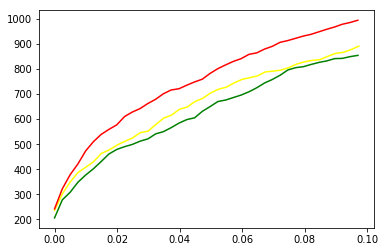

In [95]:

values, base = np.histogram(data_e, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='yellow')

values, base = np.histogram(data_mw, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='red')

values, base = np.histogram(data_tt, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='green')

In [47]:
def getFDR(df, alpha=0.05):
    dfNew = qvalues(df)
    n_falsePostive = ((dfNew["p"]<=alpha).values !=(dfNew["q"]<=alpha).values).sum()
    FDR = n_falsePostive / dfNew.shape[0]
    return FDR

# Check FDR for $\alpha = 0.05$

In [ ]:
round(getFDR(df_e, alpha=0.05) *100, 1)

In [ ]:
round(getFDR(df_mw, alpha=0.05) * 100, 1)

In [ ]:
round(getFDR(df_tt, alpha=0.05) * 100, 1)

# Check FDR for $\alpha = 0.01$

In [ ]:
round(getFDR(df_e, alpha=0.01) * 100,1)

In [ ]:
round(getFDR(df_mw, alpha=0.01) * 100, 1)

In [ ]:
round(getFDR(df_tt, alpha=0.01) * 100, 1)

# Exact test with bin size 16

In [ ]:
start = time.time()

SGM = significance_of_mean_cuda(16, dtype_v=np.uint32,dtype_A=np.float64)
SGM.run(TNP_Arr, NotTNP_Arr)
P_e_list = list(1 - SGM.p_values)

end = time.time()
print(end - start)

In [ ]:
df_e = pd.DataFrame({"p":P_e_list})


# Check FDR for $\alpha = 0.05$ 

In [ ]:
round(getFDR(df_e, alpha=0.05) * 100, 1)

# Check FDR for $\alpha = 0.01$

In [ ]:
round(getFDR(df_e, alpha=0.01) * 100, 1)